In [1]:
import pickle
import shap
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, log_loss, precision_recall_curve, roc_auc_score, \
roc_curve, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.compose import ColumnTransformer
from math import sqrt
# models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression

In [2]:
fw = open('../data/dataset_{}_{}.pickle'.format(25951,36),'rb')
df = pickle.load(fw)
df.head()

,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,ratings_ratio,...,dexion_games,laush_dmitriy_sergeevich,"nikita_""ghost_rus""",ripknot_systems,big_fish_games,sekai_project,square_enix,strategy_first,thq_nordic,ubisoft
0,0,0,124534,3339,17612,317,>5000000,7.19,127873,0.973888,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3318,633,277,62,>5000000,3.99,3951,0.839787,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3416,398,187,34,>5000000,3.99,3814,0.895648,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1273,267,258,184,>5000000,3.99,1540,0.826623,...,0,0,0,0,0,0,0,0,0,0
4,0,0,5250,288,624,415,>5000000,3.99,5538,0.947996,...,0,0,0,0,0,0,0,0,0,0


In [3]:
'../data/dataset_{}_{}.pickle'.format(25951,36)

'../data/dataset_25951_36.pickle'

In [5]:
ordinal_ftrs = ['owners', 'required_age']
ordinal_required_age = [[0, 3, 7, 12, 16, 18]]
ordinal_owners = [['0-20000', '20000-50000', '50000-100000', '100000-200000', 
                   '200000-500000', '500000-1000000', '1000000-2000000', '2000000-5000000', '>5000000']]
ordinal_price_cats = [['very cheap', 'cheap', 'moderate', 'free', 'expensive', 'very expensive']]
std_ftrs = ['positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price', 'total_ratings', 'ratings_ratio', 'achievements']
clf = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs),
        #('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('ord_age', OrdinalEncoder(categories=ordinal_required_age), ['required_age']),
        ('ord_price_cats', OrdinalEncoder(categories=ordinal_price_cats), ['price_categories'])], remainder='passthrough')
target_transformer = OrdinalEncoder(categories=ordinal_owners)
print(target_transformer.categories)

[['0-20000', '20000-50000', '50000-100000', '100000-200000', '200000-500000', '500000-1000000', '1000000-2000000', '2000000-5000000', '>5000000']]


In [6]:
def balance_dataset(df, col, ratio=0.5, balance_method='avg', random_state = 42):
    vc = df[col].value_counts()
    balanced_df = pd.DataFrame(columns=df.columns)
    if balance_method == 'avg':
        sample_size = int(df.shape[0] / len(vc))
        for i in vc.index:
            replace = (vc[i] < sample_size)
            temp = df[df[col] == i]
            balanced_df = balanced_df.append(temp.sample(n=sample_size, replace=replace, random_state=random_state), ignore_index=True)
        return balanced_df
    if balance_method == 'upward':
        highest_cat = vc.index[0]
        highest_num = vc[highest_cat]
        balanced_df = balanced_df.append(df[df[col] == highest_cat])
        for i in vc.index[1:]:
            num = vc[i]
            temp = df[df[col] == i]
            balanced_df = balanced_df.append(temp)
            sample_ratio = num / highest_num
            if sample_ratio < ratio:
                sample_size = int((ratio-sample_ratio) * highest_num)
                balanced_df = balanced_df.append(temp.sample(n=sample_size, replace=True, random_state=random_state), ignore_index=True)
        return balanced_df
    if balance_method == 'downward':
        lowest_cat = vc.index[-1]
        lowest_num = vc[lowest_cat]
        balanced_df = balanced_df.append(df[df[col] == lowest_cat])
        for i in vc.index[:-1]:
            num = vc[i]
            temp = df[df[col] == i]
            sample_ratio = lowest_num / num
            if sample_ratio < ratio:
                sample_size = int(sample_ratio * num)
                balanced_df = balanced_df.append(temp.sample(n=sample_size, replace=False, random_state=random_state), ignore_index=True)
        return balanced_df
    return None

In [12]:
def ML_pipeline_kfold(X,y,preprocessor, algo, random_state=42, resample=None):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state = random_state)
    
    # re-sample 
    if resample is not None:
        X_other['owners'] = y_other['owners']
        df = balance_dataset(X_other, 'owners', resample)
        y_other = df.loc[:, df.columns == 'owners']
        X_other = df.loc[:, df.columns != 'owners']
        
        y_other = target_transformer.fit_transform(y_other).ravel()
        y_test = target_transformer.fit_transform(y_test).ravel()
    
    # splitter for _other
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    pipe = make_pipeline(preprocessor, algo)
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [10], 'randomforestclassifier__max_features': [1.0]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, scoring='f1_weighted', return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other.ravel())
    return grid, X_test, y_test

In [13]:
y = target_transformer.fit_transform(df.loc[:, df.columns == 'owners'])
# y = df.loc[:, df.columns == 'owners']
X = df.loc[:, df.columns != 'owners']
grid, X_test, y_test = ML_pipeline_kfold(X,y,clf, RandomForestClassifier())
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

file = open('../models/RFC.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.2s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


0.7908101875222407
0.8077716387854686
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 1.0}


## Permutation Feature Importance

In [191]:
file = open('../models/RFC.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)
ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
baseline_score = f1_score(y_test, np.zeros(len(y_test)), average='weighted')
print('test score = ',test_score)
print('test baseline = ', baseline_score)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8036318268936662
test baseline =  0.554320237025041
shuffling required_age
   shuffled test score: 0.804 +/- 0.0
shuffling achievements
   shuffled test score: 0.801 +/- 0.001
shuffling positive_ratings
   shuffled test score: 0.79 +/- 0.003
shuffling negative_ratings
   shuffled test score: 0.709 +/- 0.004
shuffling average_playtime
   shuffled test score: 0.795 +/- 0.003
shuffling median_playtime
   shuffled test score: 0.774 +/- 0.002
shuffling price
   shuffled test score: 0.764 +/- 0.005
shuffling total_ratings
   shuffled test score: 0.676 +/- 0.006
shuffling ratings_ratio
   shuffled test score: 0.806 +/- 0.002
shuffling weighted_rating
   shuffled test score: 0.805 +/- 0.001
shuffling release_year
   shuffled test score: 0.754 +/- 0.002
shuffling price_categories
   shuffled test score: 0.803 +/- 0.0
shuffling multi_player
   shuffled test score: 0.803 +/- 0.001
shuffling single_player
   shuffled test score: 0.804 +/- 0.0
shuffling action
   shuffled test score

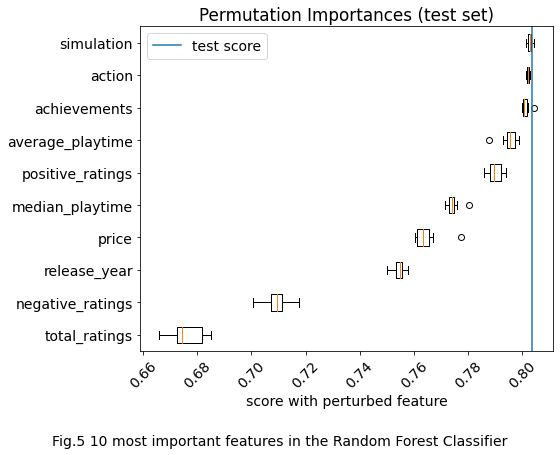

In [226]:
import matplotlib.pyplot as plt
sorted_indcs = np.argsort(np.mean(scores,axis=1))
top_ten = sorted_indcs[:10]
feature_names = df.columns
xs = [scores[i] for i in top_ten]
ys = [ftr_names[i] for i in top_ten]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(xs,labels=ys,vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.xticks(rotation=45)
plt.legend()
txt = "Fig.5 10 most important features in the Random Forest Classifier"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center')
plt.tight_layout()
plt.savefig("../figures/permutation_feature_importance.png")
plt.show()

## Shap Value

In [24]:
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(X.shape)
print(X_test.shape)
print(X_test_transformed.shape)

(25951, 35)
(2596, 35)
(2596, 35)


In [26]:
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


(2596, 35)
(9, 1000, 35)


In [27]:
feature_names = X_test.columns.values
len(feature_names)

35

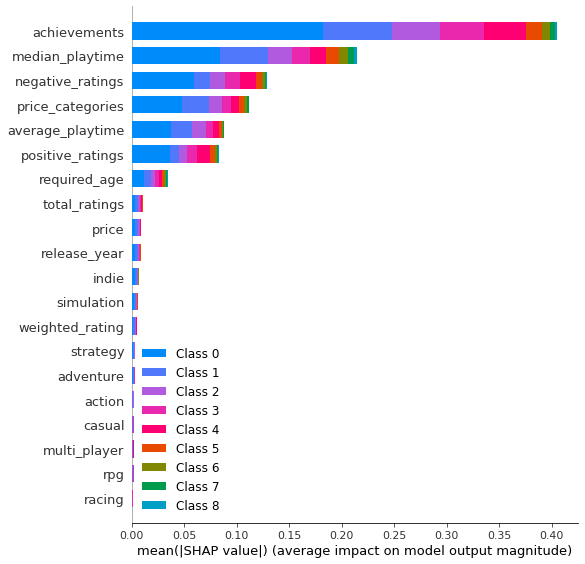

In [28]:
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names, show=False)
# plt.savefig("../figures/summary_plot.png", bbox_inches = 'tight')

## point shap value

In [55]:
import matplotlib.pyplot as plt
point = 1
temp = pd.DataFrame(data=X_test_transformed,columns = X_test.columns)
shap.force_plot(explainer.expected_value[point], shap_values[point], temp.iloc[point], show=False)
# plt.savefig("../figures/force_plot.png", bbox_inches = 'tight')

In [49]:
print(X_test.iloc[point])
print(ordinal_owners[0][int(y_test[point])])

required_age                         0
achievements                        20
positive_ratings                  5139
negative_ratings                   350
average_playtime                   245
median_playtime                    200
price                             0.79
total_ratings                     5489
ratings_ratio                 0.936236
weighted_rating                90.1191
release_year                      2015
price_categories            very cheap
multi_player                         1
single_player                        1
action                               1
adventure                            0
casual                               1
indie                                1
massively_multiplayer                0
rpg                                  0
racing                               0
simulation                           0
sports                               0
strategy                             0
choice_of_games                      0
dexion_games             

## Curves

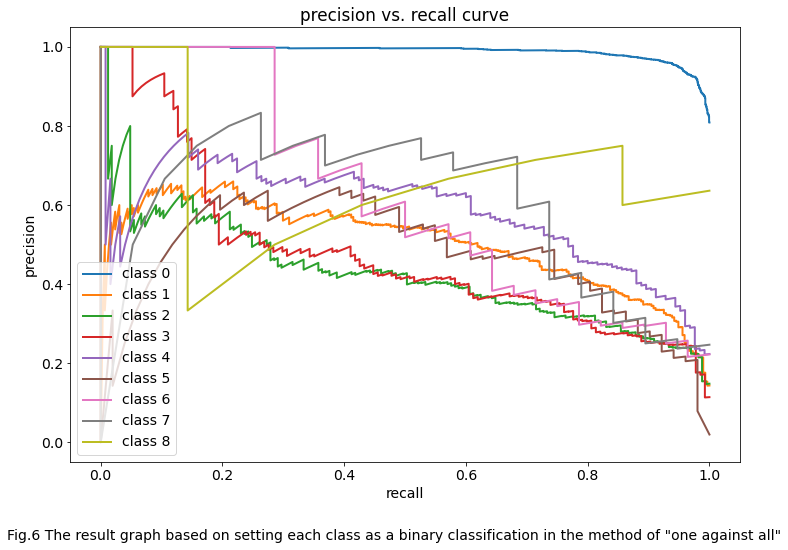

In [221]:
from sklearn.preprocessing import label_binarize
y_score = grid.predict_proba(X_test)
y_binary = label_binarize(y_test, classes=[*range(n_classes)])
precision = dict()
recall = dict()
n_classes = len(df['owners'].value_counts())
plt.figure(figsize=(12,8))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_binary[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
txt = 'Fig.6 The result graph based on setting each class as a binary classification in the method of "one against all"'
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center')
plt.savefig("../figures/precision-recall-curve.png", bbox_inches = 'tight')
plt.show()

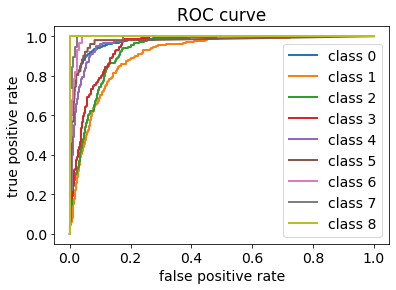

In [168]:
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

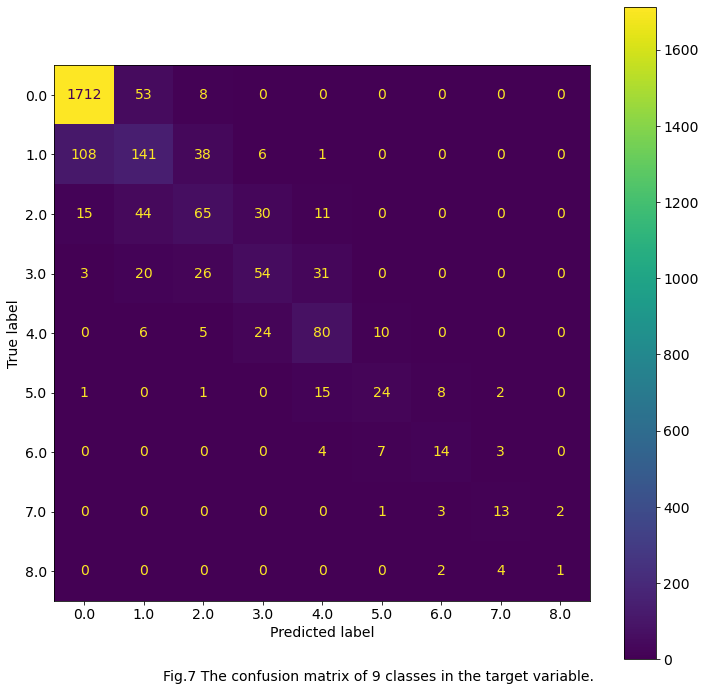

In [223]:
y_pred = grid.predict(X_test)
multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(grid,X_test,y_test, ax = ax)
txt = 'Fig.7 The confusion matrix of 9 classes in the target variable.'
plt.figtext(0.5, 0.1, txt, wrap=True, horizontalalignment='center')
plt.savefig("../figures/confusion_matrix.png", bbox_inches = 'tight')